In [1]:
# base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, KFold
from category_encoders import TargetEncoder

# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

#models
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, BaggingRegressor
from catboost import CatBoostRegressor, CatBoostClassifier

# Metrics
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score


# tunning hyperparamters model
import optuna

In [2]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')

submission = pd.read_csv('Data/sample_submission.csv')

In [3]:
# import pandas as pd
# from ydata_profiling import ProfileReport

# павп = pd.read_csv('Data/train.csv')
# фффф = ProfileReport(павп, title="Profiling Report")
# фффф

In [4]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


# 1. Preprocessing

In [5]:
nan_info = pd.DataFrame(data={'NaN_count': train.isna().sum(), 'data_type':train.dtypes})
nan_info = nan_info[nan_info['NaN_count']>0]
nan_info

,NaN_count,data_type
LotFrontage,259,float64
Alley,1369,object
MasVnrType,872,object
MasVnrArea,8,float64
BsmtQual,37,object
BsmtCond,37,object
BsmtExposure,38,object
BsmtFinType1,37,object
BsmtFinType2,38,object
Electrical,1,object


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


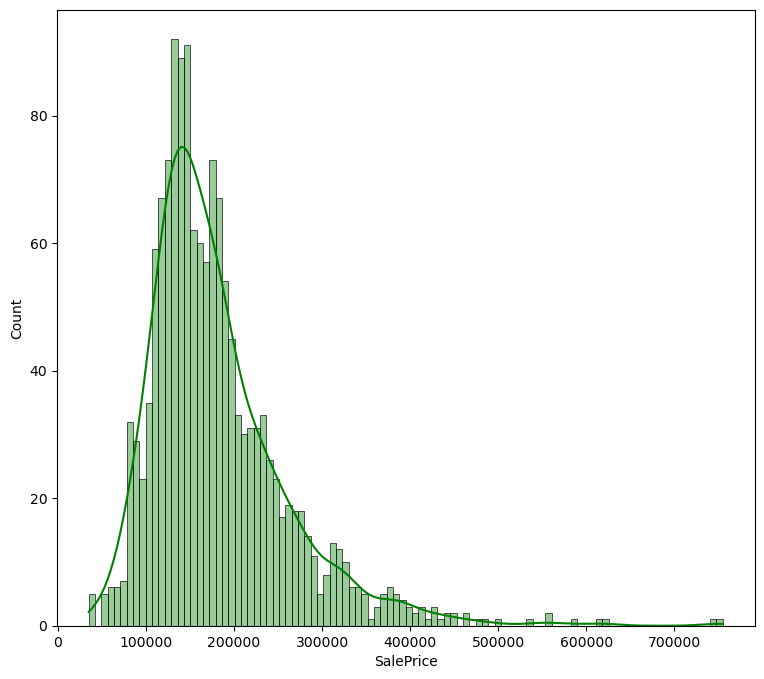

In [6]:
print(train['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.histplot(train['SalePrice'], color='g', bins=100, kde=100, alpha=0.4);

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Numerical data distribution

In [8]:
numeric_columns = train.select_dtypes(include=['number']).columns
print("Числовые столбцы:", numeric_columns)

categorical_columns = train.select_dtypes(include=['object']).columns
print("Категориальные столбцы:", categorical_columns)

Числовые столбцы: Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
Категориальные столбцы: Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinT

In [9]:
list(set(train.dtypes.tolist()))

[dtype('float64'), dtype('O'), dtype('int64')]

In [10]:
df_num = train.select_dtypes(include= ['float64', 'int64'])
df_num.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


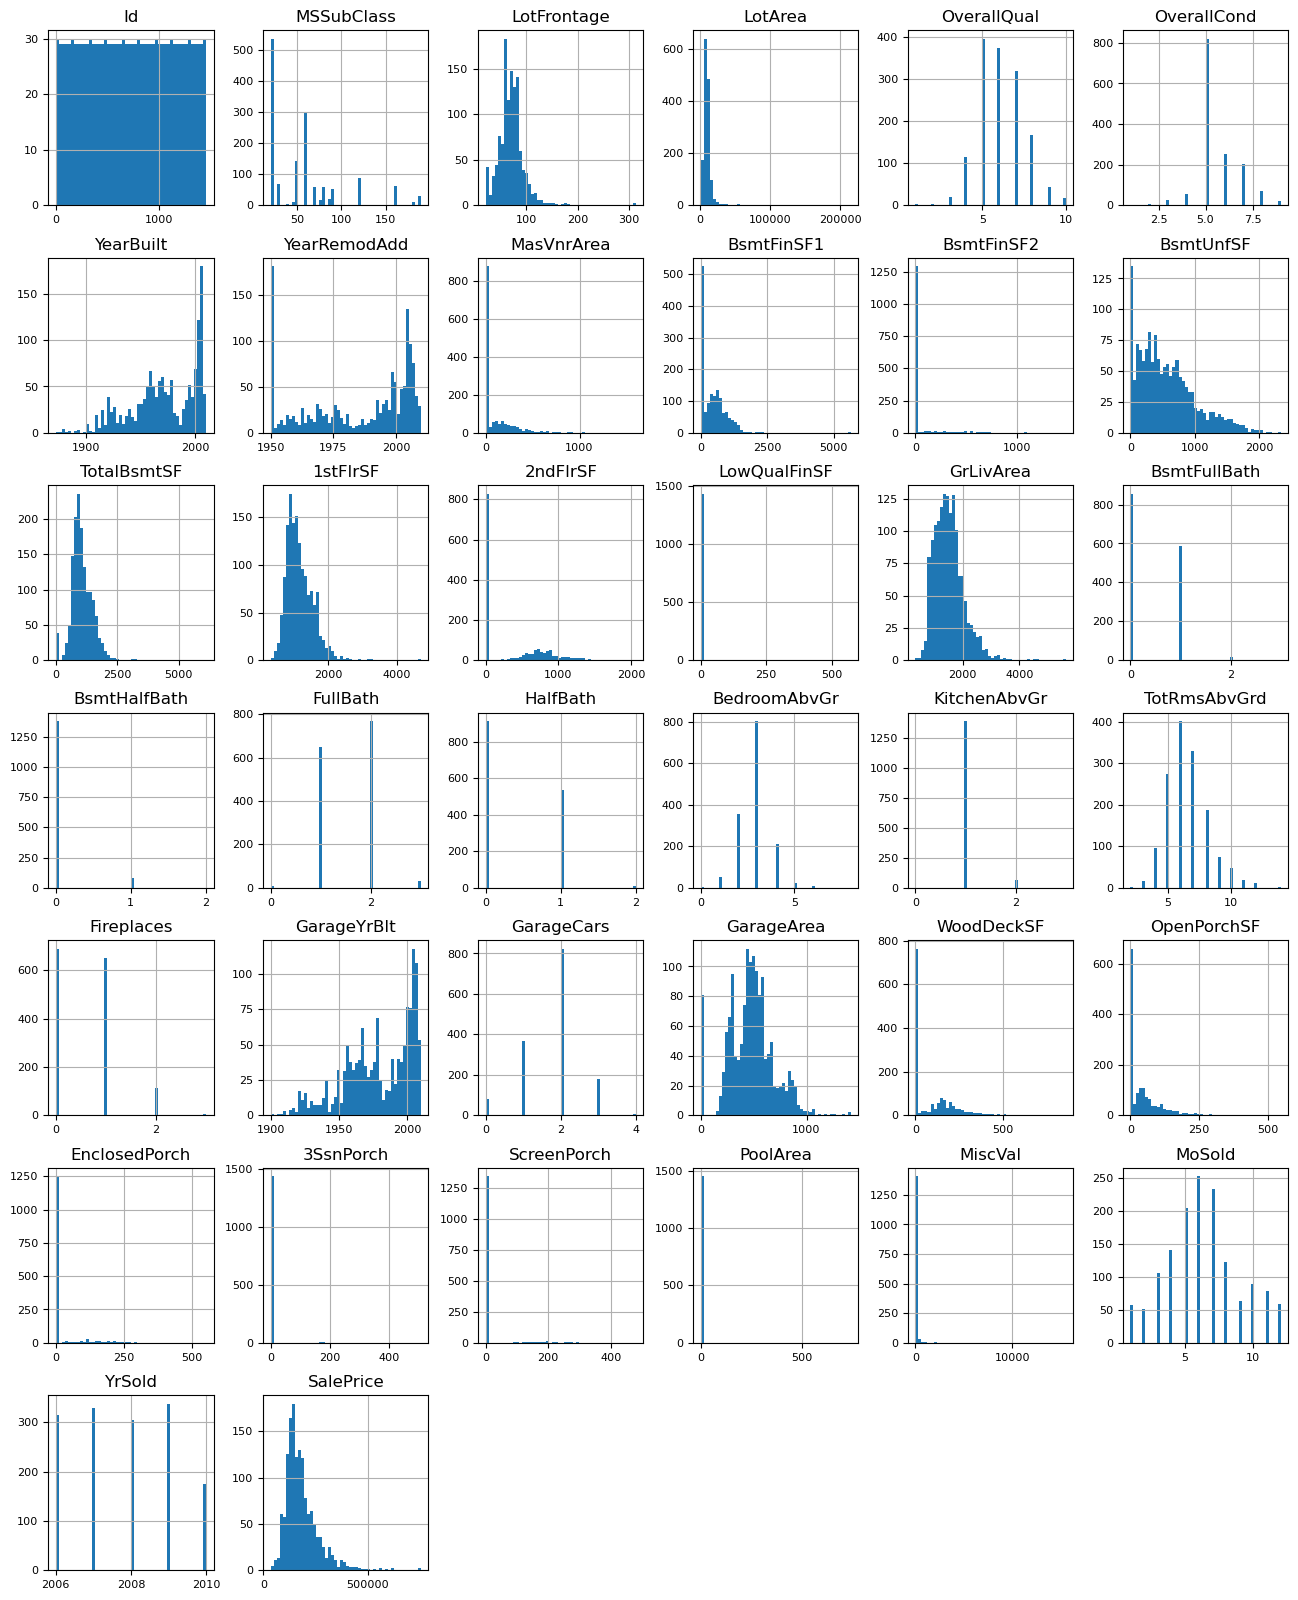

In [11]:
df_num.hist(figsize=(16,20), bins=50, xlabelsize=8, ylabelsize=8);

In [ ]:
# Определение целевой переменной и признаков
label = 'SalePrice'
X = train.drop(columns=[label])  # все признаки, кроме целевого
y = train[label]                 # целевая переменная

# Разделение на тренировочную и тестовую выборки
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"{len(X_train)} примеров в тренировочном наборе, {len(X_valid)} примеров в тестовом наборе.")

1168 примеров в тренировочном наборе, 292 примеров в тестовом наборе.


In [13]:
nan_info = nan_info.reset_index()
nan_info

,index,NaN_count,data_type
0,LotFrontage,259,float64
1,Alley,1369,object
2,MasVnrType,872,object
3,MasVnrArea,8,float64
4,BsmtQual,37,object
5,BsmtCond,37,object
6,BsmtExposure,38,object
7,BsmtFinType1,37,object
8,BsmtFinType2,38,object
9,Electrical,1,object


In [14]:
X_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
254,255,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1066,1067,60,RL,59.0,7837,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal
638,639,30,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,5,2008,WD,Normal
799,800,50,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal
380,381,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,1096,20,RL,78.0,9317,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal
1130,1131,50,RL,65.0,7804,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,12,2009,WD,Normal
1294,1295,20,RL,60.0,8172,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Normal
860,861,50,RL,55.0,7642,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,GdPrv,NaN,0,6,2007,WD,Normal


In [15]:

drop_features = ['MasVnrType', 'Alley', 'MasVnrArea', 'Id'] # Эти столбцы считаем не нужными и выкидываем
na_features = nan_info.loc[nan_info['data_type'] == 'object', 'index'].tolist()
na_features = [x for x in na_features if x not in ['Electrical', 'MasVnrType', 'Alley', 'Id']] 

# Начинаем создавать наш Pipeline
imputer = ColumnTransformer(
    transformers = [
        ('drop_features', 'drop', drop_features),
        ('num_imputer', SimpleImputer(strategy='median'), ['GarageYrBlt', 'LotFrontage']), 
        ('cat_imputer', SimpleImputer(strategy='constant', fill_value='NA'), na_features),
        ('el_imputer', SimpleImputer(strategy='most_frequent'), ['Electrical'])
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough',
    force_int_remainder_cols=False
)    
filled_data = imputer.fit_transform(X_train)
filled_data

,GarageYrBlt,LotFrontage,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,FireplaceQu,GarageType,GarageFinish,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
254,1957.0,70.0,TA,TA,No,Rec,Unf,NA,Attchd,RFn,...,0,0,0,0,0,0,6,2010,WD,Normal
1066,1993.0,59.0,Gd,TA,No,Unf,Unf,TA,Attchd,RFn,...,40,0,0,0,0,0,5,2009,WD,Normal
638,1980.0,67.0,Fa,TA,No,Unf,Unf,NA,NA,NA,...,0,164,0,0,0,0,5,2008,WD,Normal
799,1939.0,60.0,Gd,TA,No,ALQ,Unf,TA,Detchd,Unf,...,0,264,0,0,0,0,6,2007,WD,Normal
380,1924.0,50.0,TA,TA,No,LwQ,Unf,Gd,Detchd,Unf,...,0,242,0,0,0,0,5,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,2006.0,78.0,Gd,TA,No,GLQ,Unf,Gd,Attchd,RFn,...,22,0,0,0,0,0,3,2007,WD,Normal
1130,1981.0,65.0,TA,TA,No,BLQ,Unf,TA,Detchd,Unf,...,44,0,0,0,0,0,12,2009,WD,Normal
1294,1957.0,60.0,TA,TA,No,Rec,Unf,NA,Detchd,Unf,...,0,0,0,0,0,0,4,2006,WD,Normal
860,1925.0,55.0,TA,TA,No,Unf,Unf,Gd,Detchd,Unf,...,240,0,0,0,0,0,6,2007,WD,Normal


In [16]:
imputer

ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                  transformers=[('drop_features', 'drop',
                                 ['MasVnrType', 'Alley', 'MasVnrArea', 'Id']),
                                ('num_imputer',
                                 SimpleImputer(strategy='median'),
                                 ['GarageYrBlt', 'LotFrontage']),
                                ('cat_imputer',
                                 SimpleImputer(fill_value='NA',
                                               strategy='constant'),
                                 ['BsmtQual', 'BsmtCond', 'BsmtExposure',
                                  'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
                                  'GarageType', 'GarageFinish', 'GarageQual',
                                  'GarageCond', 'PoolQC', 'Fence',
                                  'MiscFeature']),
                                ('el_imputer',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['Electrical'])],
                  verbose_feature_names_out=False)

,GarageYrBlt,LotFrontage,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
254,1957.0,70.0,20,8400,5,6,1957,1957,922,0,...,250,0,0,0,0,0,0,6,2010,145000
1066,1993.0,59.0,60,7837,6,7,1993,1994,0,0,...,0,40,0,0,0,0,0,5,2009,178000
638,1980.0,67.0,30,8777,5,7,1910,1950,0,0,...,328,0,164,0,0,0,0,5,2008,85000
799,1939.0,60.0,50,7200,5,7,1937,1950,569,0,...,0,0,264,0,0,0,0,6,2007,175000
380,1924.0,50.0,50,5000,5,6,1924,1950,218,0,...,0,0,242,0,0,0,0,5,2010,127000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,2006.0,78.0,20,9317,6,5,2006,2006,24,0,...,0,22,0,0,0,0,0,3,2007,176432
1130,1981.0,65.0,50,7804,4,3,1928,1950,622,0,...,431,44,0,0,0,0,0,12,2009,135000
1294,1957.0,60.0,20,8172,5,7,1955,1990,167,0,...,0,0,0,0,0,0,0,4,2006,115000
860,1925.0,55.0,50,7642,7,8,1918,1998,0,0,...,0,240,0,0,0,0,0,6,2007,189950


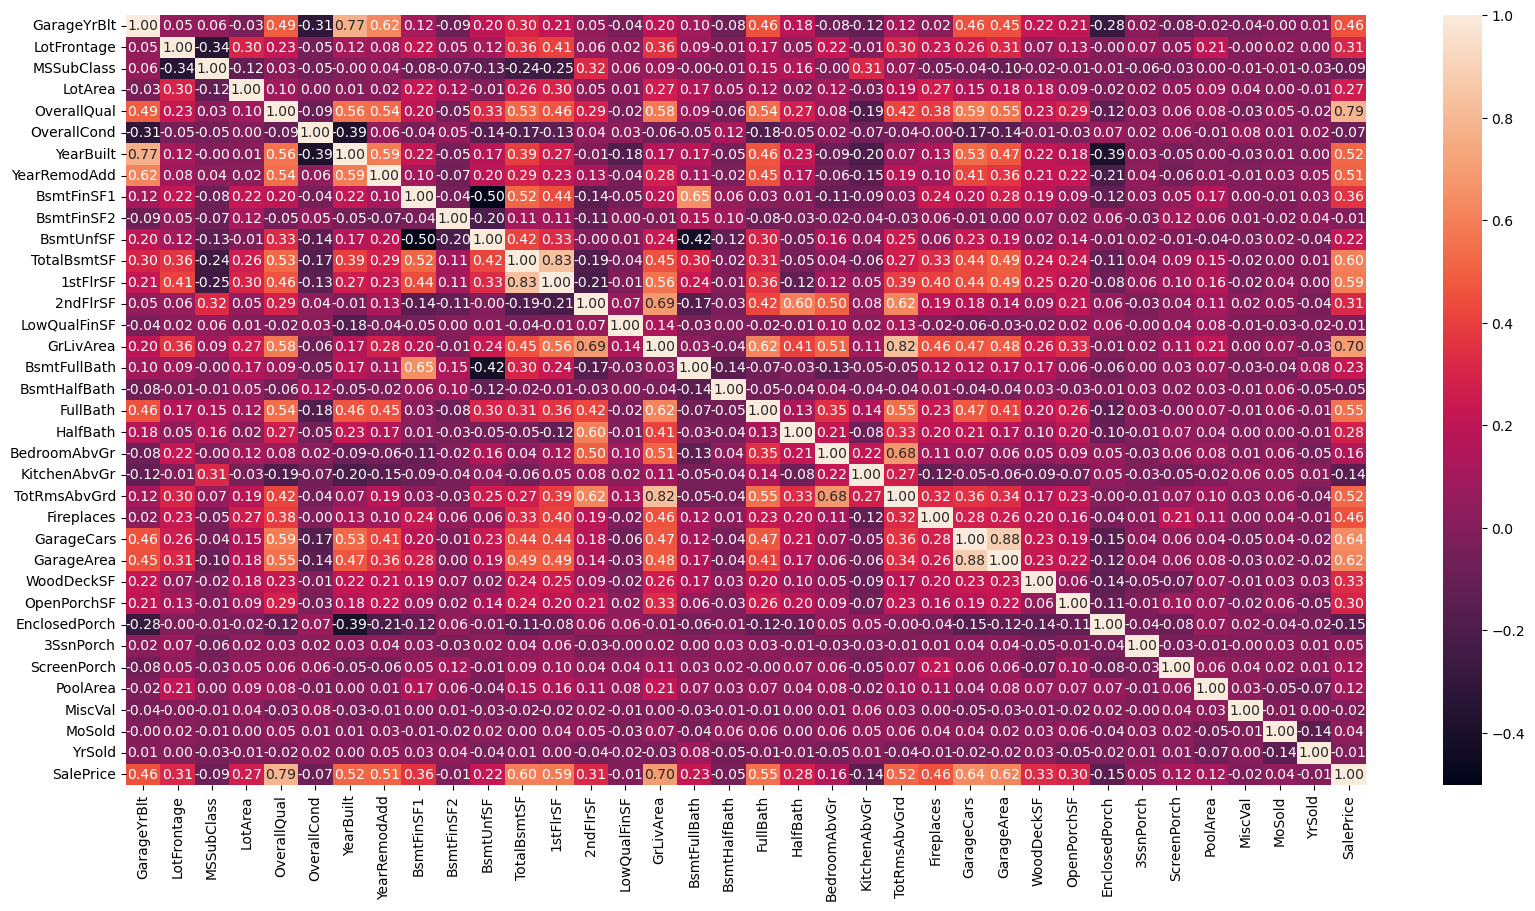

In [17]:
# Посмотрим кореляцию признаков и их влияние на SalePrice

corr_data = pd.concat([filled_data, y_train], axis=1)
num_features = corr_data.select_dtypes(exclude='object')
plt.figure(figsize=(20, 10))
sns.heatmap(num_features.corr(), annot=True, fmt='.2f');
num_features

In [18]:
# Кодирование данных

target_encoder_cat = ['BsmtQual','BsmtCond','FireplaceQu', 'GarageQual', 'GarageCond', 'KitchenQual', 'HeatingQC', 'ExterCond', 'ExterQual', "BsmtFinType1",
                      "BsmtFinType2", 'Fence', 'PoolQC', 'Functional', 'PavedDrive', 'GarageFinish', 'BsmtExposure', 'HouseStyle', 'SaleCondition', 'SaleType',
                      'MiscFeature', 'GarageType', 'Electrical', 'Heating', 'Foundation', 'Exterior2nd', 'Exterior1st', 'RoofMatl', 'RoofStyle', 'BldgType',
                      'Condition1', 'LandSlope', 'Neighborhood', 'LotConfig', 'Utilities', 'LandContour', 'LotShape', 'Street', 'MSZoning', 'MSSubClass', 'Condition2']

encoder = ColumnTransformer(
    [

        ('central_air', OrdinalEncoder(), ['CentralAir']),
        ('target_encoder', TargetEncoder(), target_encoder_cat)

    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough',
    force_int_remainder_cols=False
)
encoded_data = encoder.fit_transform(filled_data, y_train)

In [19]:
encoder

ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                  transformers=[('central_air', OrdinalEncoder(),
                                 ['CentralAir']),
                                ('target_encoder', TargetEncoder(),
                                 ['BsmtQual', 'BsmtCond', 'FireplaceQu',
                                  'GarageQual', 'GarageCond', 'KitchenQual',
                                  'HeatingQC', 'ExterCond', 'ExterQual',
                                  'BsmtFinType1', 'BsmtFinType2', 'Fence',
                                  'PoolQC', 'Functional', 'PavedDrive',
                                  'GarageFinish', 'BsmtExposure', 'HouseStyle',
                                  'SaleCondition', 'SaleType', 'MiscFeature',
                                  'GarageType', 'Electrical', 'Heating',
                                  'Foundation', 'Exterior2nd', 'Exterior1st',
                                  'RoofMatl', 'RoofStyle', 'BldgType', ...])],
                  verbose_feature_names_out=False)

In [20]:
standard_scaler_columns = encoded_data.columns.to_list()

scaler = ColumnTransformer(
    [
        ('scaling_num_columns', StandardScaler(), standard_scaler_columns)
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough',
    force_int_remainder_cols=False
)
processed_data = scaler.fit_transform(encoded_data)

In [21]:
scaler

ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                  transformers=[('scaling_num_columns', StandardScaler(),
                                 ['CentralAir', 'BsmtQual', 'BsmtCond',
                                  'FireplaceQu', 'GarageQual', 'GarageCond',
                                  'KitchenQual', 'HeatingQC', 'ExterCond',
                                  'ExterQual', 'BsmtFinType1', 'BsmtFinType2',
                                  'Fence', 'PoolQC', 'Functional', 'PavedDrive',
                                  'GarageFinish', 'BsmtExposure', 'HouseStyle',
                                  'SaleCondition', 'SaleType', 'MiscFeature',
                                  'GarageType', 'Electrical', 'Heating',
                                  'Foundation', 'Exterior2nd', 'Exterior1st',
                                  'RoofMatl', 'RoofStyle', ...])],
                  verbose_feature_names_out=False)

In [22]:
processed_data.head(5)

,CentralAir,BsmtQual,BsmtCond,FireplaceQu,GarageQual,GarageCond,KitchenQual,HeatingQC,ExterCond,ExterQual,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
254,0.276582,-0.783872,0.139339,-1.008667,0.296366,0.291152,-0.768410,-1.078044,-1.725549,-0.708313,...,-0.863837,1.188402,-0.714352,-0.351921,-0.121008,-0.275838,-0.070993,-0.09274,-0.133417,1.650065
1066,0.276582,0.407188,0.139339,0.668603,0.296366,0.291152,-0.768410,-0.749643,0.333854,1.003695,...,-0.456264,-0.740157,-0.138015,-0.351921,-0.121008,-0.275838,-0.070993,-0.09274,-0.508010,0.893677
638,0.276582,-0.886696,0.139339,-1.008667,-3.732213,-3.861094,-0.768410,-0.749643,0.333854,-0.708313,...,-2.257169,1.790113,-0.714352,2.290826,-0.121008,-0.275838,-0.070993,-0.09274,-0.508010,0.137290
799,0.276582,0.407188,0.139339,0.668603,0.296366,0.291152,0.571014,0.992719,0.333854,-0.708313,...,-1.119755,-0.740157,-0.714352,3.902257,-0.121008,-0.275838,-0.070993,-0.09274,-0.133417,-0.619098
380,0.276582,-0.783872,0.139339,1.168823,0.296366,0.291152,0.571014,-1.078044,0.333854,-0.708313,...,-0.797488,-0.740157,-0.714352,3.547742,-0.121008,-0.275838,-0.070993,-0.09274,-0.508010,1.650065


In [23]:
preprocessor = Pipeline(
    [
        ('imputer', imputer),
        ('encoder', encoder),
        ('scaler', scaler)
    ]
)
preprocessor

Pipeline(steps=[('imputer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('drop_features', 'drop',
                                                  ['MasVnrType', 'Alley',
                                                   'MasVnrArea', 'Id']),
                                                 ('num_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['GarageYrBlt',
                                                   'LotFrontage']),
                                                 ('cat_imputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant'),
                                                  ['BsmtQual', 'BsmtCond',
                                                   'B...
                                                   'GarageQual', 'GarageCond',
                                                   'KitchenQual', 'HeatingQC',
                                                   'ExterCond', 'ExterQual',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Fence',
                                                   'PoolQC', 'Functional',
                                                   'PavedDrive', 'GarageFinish',
                                                   'BsmtExposure', 'HouseStyle',
                                                   'SaleCondition', 'SaleType',
                                                   'MiscFeature', 'GarageType',
                                                   'Electrical', 'Heating',
                                                   'Foundation', 'Exterior2nd',
                                                   'Exterior1st', 'RoofMatl',
                                                   'RoofStyle', ...])],
                                   verbose_feature_names_out=False))])

In [24]:
# pipeline = Pipeline(steps=[
#     ('preprocessing', scaler_and_encoder),
#     ('model', RandomForestRegressor())  # Здесь используется RandomForestRegressor в качестве примера
# ])

# # Шаг 4: Проведение кросс-валидации с конвейером
# # Применение кросс-валидации к pipeline с использованием KFold
# scores = cross_val_score(pipeline, filled_data, y_train, cv=kf, scoring='neg_mean_squared_error')

# # Вывод метрик
# print("Средняя ошибка по фолдам:", -scores.mean())
# print("Стандартное отклонение ошибки по фолдам:", scores.std())

In [25]:
preprocessor.fit_transform(X_train, y_train)

,CentralAir,BsmtQual,BsmtCond,FireplaceQu,GarageQual,GarageCond,KitchenQual,HeatingQC,ExterCond,ExterQual,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
254,0.276582,-0.783872,0.139339,-1.008667,0.296366,0.291152,-0.768410,-1.078044,-1.725549,-0.708313,...,-0.863837,1.188402,-0.714352,-0.351921,-0.121008,-0.275838,-0.070993,-0.09274,-0.133417,1.650065
1066,0.276582,0.407188,0.139339,0.668603,0.296366,0.291152,-0.768410,-0.749643,0.333854,1.003695,...,-0.456264,-0.740157,-0.138015,-0.351921,-0.121008,-0.275838,-0.070993,-0.09274,-0.508010,0.893677
638,0.276582,-0.886696,0.139339,-1.008667,-3.732213,-3.861094,-0.768410,-0.749643,0.333854,-0.708313,...,-2.257169,1.790113,-0.714352,2.290826,-0.121008,-0.275838,-0.070993,-0.09274,-0.508010,0.137290
799,0.276582,0.407188,0.139339,0.668603,0.296366,0.291152,0.571014,0.992719,0.333854,-0.708313,...,-1.119755,-0.740157,-0.714352,3.902257,-0.121008,-0.275838,-0.070993,-0.09274,-0.133417,-0.619098
380,0.276582,-0.783872,0.139339,1.168823,0.296366,0.291152,0.571014,-1.078044,0.333854,-0.708313,...,-0.797488,-0.740157,-0.714352,3.547742,-0.121008,-0.275838,-0.070993,-0.09274,-0.508010,1.650065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,0.276582,0.407188,0.139339,1.168823,0.296366,0.291152,0.571014,-0.749643,0.333854,1.003695,...,-0.171910,-0.740157,-0.397367,-0.351921,-0.121008,-0.275838,-0.070993,-0.09274,-1.257196,-0.619098
1130,0.276582,-0.783872,0.139339,0.668603,0.296366,0.291152,0.571014,-1.078044,0.333854,-0.708313,...,0.472624,2.584680,-0.080381,-0.351921,-0.121008,-0.275838,-0.070993,-0.09274,2.114141,0.893677
1294,0.276582,-0.783872,0.139339,-1.008667,0.296366,0.291152,-0.768410,-1.078044,0.333854,-0.708313,...,0.453667,-0.740157,-0.714352,-0.351921,-0.121008,-0.275838,-0.070993,-0.09274,-0.882603,-1.375486
860,0.276582,-0.783872,0.139339,1.168823,0.296366,0.291152,0.571014,-0.749643,0.333854,1.003695,...,-1.233497,-0.740157,2.743670,-0.351921,-0.121008,-0.275838,-0.070993,-0.09274,-0.133417,-0.619098


In [26]:
# cb = CatBoostClassifier(eval_metric='Accuracy')

# cb.fit(
#     X_train,
#     y_train,
#     eval_set=(X_valid, y_valid),
#     plot=True
# )

In [27]:
preprocessor

Pipeline(steps=[('imputer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('drop_features', 'drop',
                                                  ['MasVnrType', 'Alley',
                                                   'MasVnrArea', 'Id']),
                                                 ('num_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['GarageYrBlt',
                                                   'LotFrontage']),
                                                 ('cat_imputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant'),
                                                  ['BsmtQual', 'BsmtCond',
                                                   'B...
                                                   'GarageQual', 'GarageCond',
                                                   'KitchenQual', 'HeatingQC',
                                                   'ExterCond', 'ExterQual',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Fence',
                                                   'PoolQC', 'Functional',
                                                   'PavedDrive', 'GarageFinish',
                                                   'BsmtExposure', 'HouseStyle',
                                                   'SaleCondition', 'SaleType',
                                                   'MiscFeature', 'GarageType',
                                                   'Electrical', 'Heating',
                                                   'Foundation', 'Exterior2nd',
                                                   'Exterior1st', 'RoofMatl',
                                                   'RoofStyle', ...])],
                                   verbose_feature_names_out=False))])

In [28]:
# Получаем уникальные классы
train_classes = set(y_train.unique())
valid_classes = set(y_valid.unique())

# Находим отсутствующие классы в обучающем наборе
missing_in_train = valid_classes - train_classes
missing_in_valid = train_classes - valid_classes

# Выводим результаты
print("Классы, отсутствующие в обучающем наборе:", missing_in_train)
print("Классы, отсутствующие в валидационном наборе:", missing_in_valid)



Классы, отсутствующие в обучающем наборе: {169990, 341000, 255000, 276000, 556581, 297000, 185900, 254000, 403000, 104000, 360000, 40000, 311872, 135750, 317000, 253000, 118858, 183900, 337500, 204900, 465000, 315500, 318061, 144500, 118400, 79500, 192140, 194201, 91300, 244400, 55993, 155835, 154300, 367294, 128200, 130250, 311500, 183500, 293077, 187100, 165600, 75500, 369900, 395000, 75000, 155900, 154900, 103200, 134432, 68400, 246578, 243000, 755000, 93500, 283463, 131400, 611657, 195400, 135500, 156500, 284000, 348000, 92000, 305000, 253293, 451950, 102776, 107900, 89471, 154500, 239500, 181134, 68500, 185750, 217500, 108959, 84900, 101800, 105900, 200624, 128950, 67000, 173500, 108480, 264132, 66500, 301000, 109008, 153575, 35311, 64500, 438780}
Классы, отсутствующие в валидационном наборе: {256000, 106500, 170000, 426000, 122900, 79900, 340000, 84000, 147500, 206900, 211000, 163900, 168000, 239686, 125000, 381000, 219210, 231500, 501837, 82000, 229456, 34900, 188500, 295000, 14

In [1]:
# preprocessor.fit(X_train, y_train)
# preprocessed_X_train = preprocessor.transform(X_train)
# preprocessed_X_valid = preprocessor.transform(X_valid)
# valid_mask = y_valid.isin(y_train.unique())
# y_valid_filtered = y_valid[valid_mask]
# X_valid_filtered = X_valid[valid_mask]
# preprocessed_X_valid = preprocessor.transform(X_valid_filtered)

# cb = CatBoostClassifier(eval_metric='Accuracy')

# cb.fit(
#     preprocessed_X_train,
#     y_train,
#     eval_set=(preprocessed_X_valid, y_valid_filtered),
#     plot=True
# )

In [ ]:
# Инициализация модели случайного леса
rf_model = RandomForestRegressor(random_state=42)

In [ ]:

# Создание модели с пайплайном
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Обучение модели
rf_pipeline.fit(X_train, y_train)

# Оценка модели
y_pred = rf_pipeline.predict(X_valid)

In [ ]:
# Оценка модели на валидационной выборке
mse = mean_squared_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print(f"Среднеквадратическая ошибка (MSE): {mse}")
print(f"Коэффициент детерминации (R²): {r2}")

Среднеквадратическая ошибка (MSE): 820713443.2236415
Коэффициент детерминации (R²): 0.8930014941926943


In [ ]:
# Расчет RMSE
rmse = np.sqrt(mse)
print(f"Корень среднеквадратической ошибки (RMSE): {rmse}")

Корень среднеквадратической ошибки (RMSE): 28648.096677155387


In [ ]:
# # Прогнозирование с помощью модели, обученной на sklearn
preds = rf_pipeline.predict(test)
preds
# # Создание DataFrame с результатами
output = pd.DataFrame({'Id': test['Id'], 'SalePrice': preds})

# # Вывод первых строк для проверки
output.head()

,Id,SalePrice
0,1461,126601.00
1,1462,153108.00
2,1463,186762.65
3,1464,192456.30
4,1465,206298.33


In [ ]:
# output.to_csv('sabmission2.csv', index=False)